# Getting Organized

In [1]:
import numpy as np
np.random.seed(42)
import os

# Plotting
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

# Pandas
import pandas as pd

# RYO
from app.ts_decomposition.data.energy_connection import EnergyConnection
from app.ts_decomposition.model.series_sample import TimeSeriesSample



# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

/home/nathaniel/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Config
PROJECT_ROOT_DIR = "."
PROJECT_DATA_DIR = os.path.join(PROJECT_ROOT_DIR, 'data')


# Save Images
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")

# File
FILE_NAME = "energydata_complete.csv"

In [3]:
# Util Funcs
def load_data(file_name, data_path="."):
    csv_path = os.path.join(data_path, file_name)
    return pd.read_csv(csv_path)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


# Load Data from Influx
*If there are no room readings, it is because I have not worked through that part of the TimeSeriesSample lib

In [10]:
energy_connection = EnergyConnection()

# Generate frames from connections
sample_frame = energy_connection.sample_series('energy_readings')

# TODO: Rooms/QL Extract

sample_frame = energy_connection.sample_series('external_readings', append_frame=sample_frame)

# Add to object
sample = TimeSeriesSample(sample_frame, 'time')

sample.base.describe()

,appliance,light,humidity,pressure,tdewpoint,tempurature,visibility,windspeed
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,79.750418,755.522602,3.760707,7.411665,38.330834,4.039752
std,102.524891,7.935988,14.901088,7.399441,4.194648,5.317409,11.794719,2.451221
min,10.000000,0.000000,24.000000,729.300000,-6.600000,-5.000000,1.000000,0.000000
25%,50.000000,0.000000,70.333333,750.933333,0.900000,3.666667,29.000000,2.000000
50%,60.000000,0.000000,83.666667,756.100000,3.433333,6.916667,40.000000,3.666667
75%,100.000000,0.000000,91.666667,760.933333,6.566667,10.408333,40.000000,5.500000
max,1080.000000,70.000000,100.000000,772.300000,15.500000,26.100000,66.000000,14.000000


In [11]:
#TODO: Broken bc time is now the actual index, need to modify w/o 'key' 
# Decomp
sample.day_of_week_class()
sample.weekend_weekday_class()

sample.clean_lights()

sample.base.describe()

ValueError: cannot label index with a null key

In [12]:
sample.train_test_split(20)
sample.base.describe()
#sample.base_valid.describe()

,appliance,light,humidity,pressure,tdewpoint,tempurature,visibility,windspeed
count,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000
mean,98.024449,4.314036,81.834642,755.401923,2.731101,5.855215,38.672314,4.276856
std,105.198291,8.363499,12.920004,7.778350,3.523068,4.129179,12.402705,2.555565
min,10.000000,0.000000,31.000000,729.300000,-6.600000,-5.000000,1.000000,0.000000
25%,50.000000,0.000000,73.333333,750.600000,0.400000,2.950000,29.000000,2.000000
50%,60.000000,0.000000,85.333333,755.933333,2.757143,5.800000,40.000000,4.000000
75%,100.000000,10.000000,92.000000,761.366667,5.200000,8.800000,40.000000,6.000000
max,1080.000000,70.000000,100.000000,772.300000,11.400000,19.700000,66.000000,14.000000


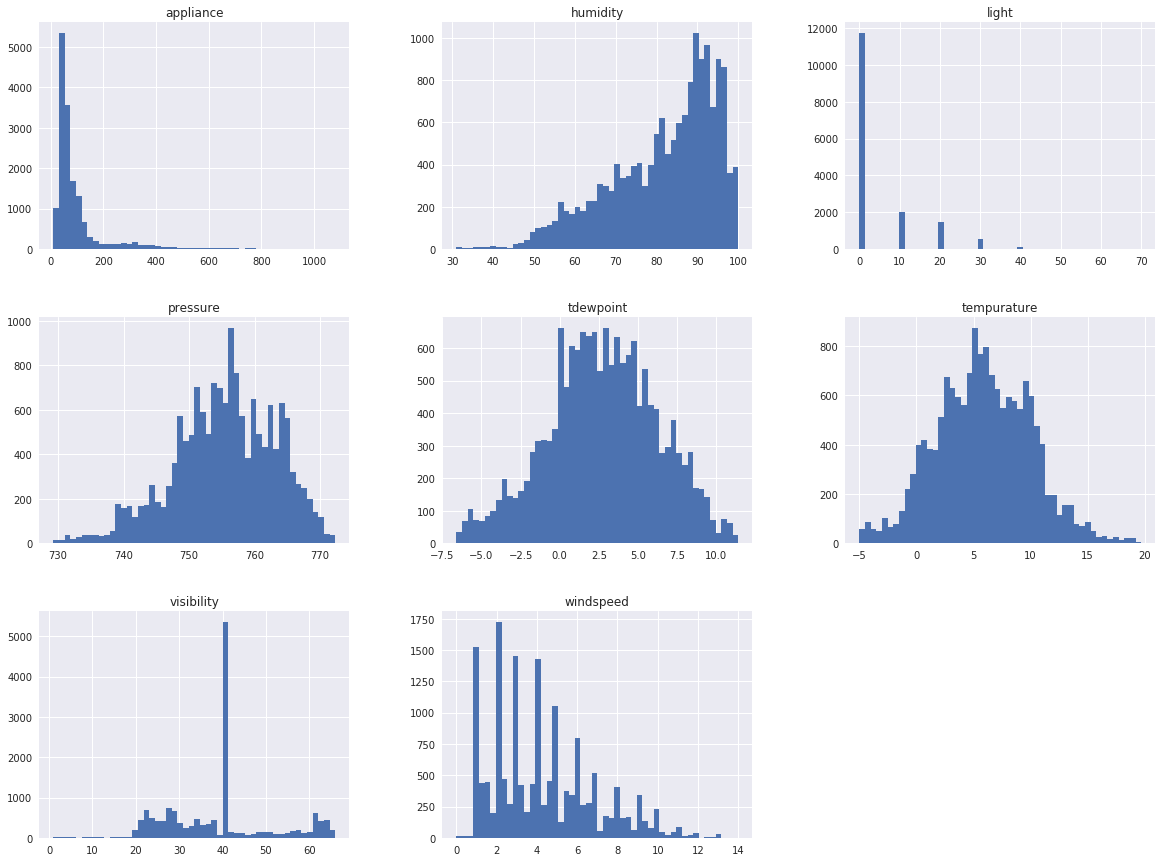

In [14]:
%matplotlib inline

import matplotlib.pyplot as plt

sample.base.hist(bins=50, figsize=(20,15))
plt.show()

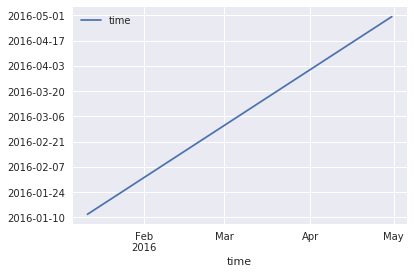

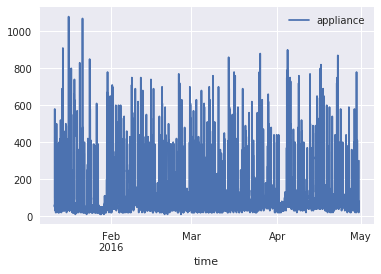

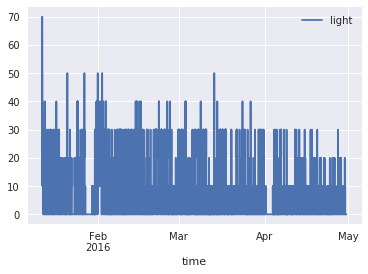

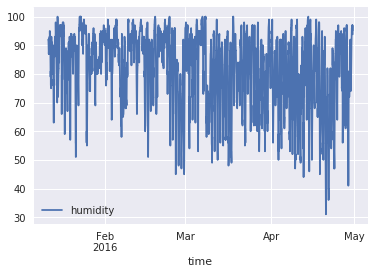

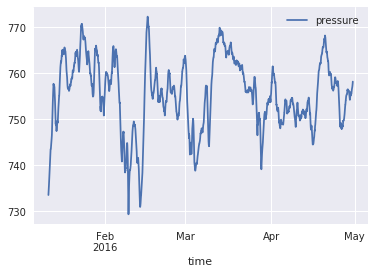

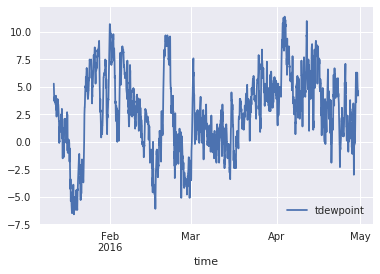

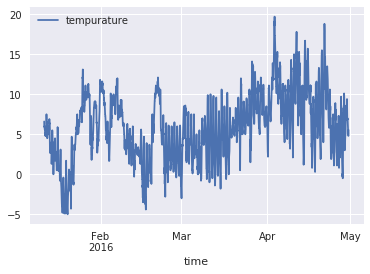

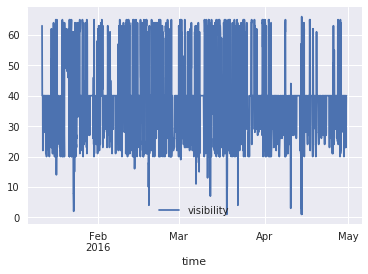

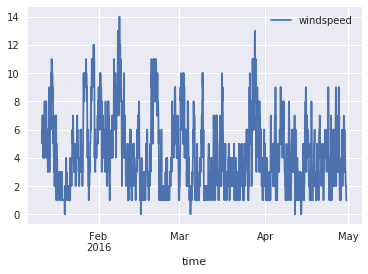

In [15]:
%matplotlib inline
ignore = ['sourceid_x', 'sourceid_y']

cat = [
    'light',
    'light_cleaned',
    'light_on',
    'visibility',
    'day_of_week_class',
    'weekend_weekday_class'
]

sample.categorical_features = cat

for series in sample.base:

    if series not in ignore:
        #print(series)
        sample.base.plot(kind='line', x=sample.base.index, y=series)

plt.show()

# Now we can observe (read: clean)

### Analog Signal ?
Appliances: Standard Dev is high compared to mean, especially factoring in min and max. So, we will have a big initial hump (maybe close to localized normal), and some BIG positive outliers

Lights: 
    - a lot of time on 0, maybe we can catogorize/bin this val
    - Super stochastic?
    - fuzzy => off, low, mid, hi?
    
### Digital Signal?
Visibility: 
    - one huge bin?
    - Split into two "non 40" vars, take the hist there?
    - Check: three fuzzy blocks?
    
Windspeed: Levels?

Temps:
    - "Spikey bins"? => Equilibrium point/level?
    - otherwise center lump
    
Humidity:
    - left side lump
    - but one is flat?
    - definitely some cutoff
    

# TODO: 
Switch to TS Object from lib
Make the influx cutoff from there

Two sided structure: 
    - dataframe for Jupyter Analytics
    - Array for implimented ML algorithms
    

# Go through the series 

In [16]:
# Stationality 
from statsmodels.tsa.stattools import adfuller

# Autocorr
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Decomps
from statsmodels.tsa.seasonal import seasonal_decompose

from stldecompose import decompose

# ARIMA
from statsmodels.tsa.arima_model import ARIMA
# Resid
from numpy import histogram

# Jupyter
from matplotlib import pyplot



from pandas import Series
from matplotlib import pyplot
from numpy import log

# Appliance Energy


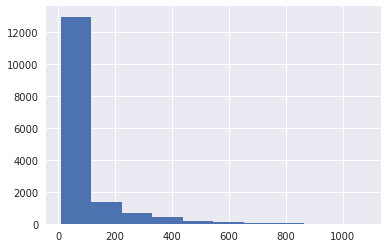

In [45]:
series='appliance'
sample.base[series].hist()

plt.show()

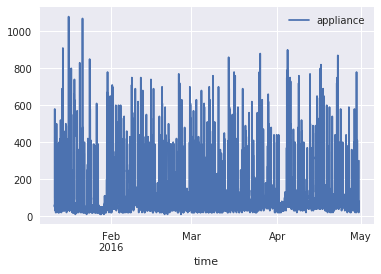

In [48]:
sample.base.plot(kind='line', x=sample.base.index, y=series)

/home/nathaniel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


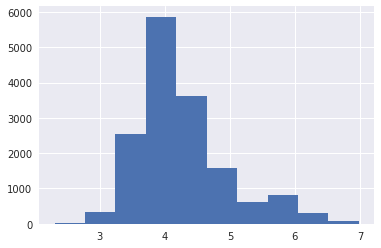

In [46]:
series_log = series + '_log'

X = sample.base[series].values
#series_log = Series(log(X))
sample.base[series_log] = log(X)

#sample.base[series_log].plot()
sample.base[series_log].hist()

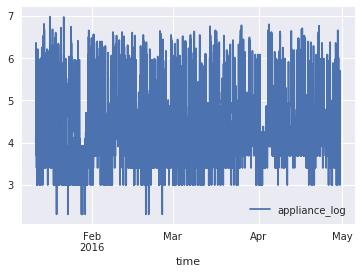

In [49]:
sample.base.plot(kind='line', x=sample.base.index, y=series_log)

Log gets you something a little more gaussian, I think energy is looking more like a Poisson.

### Stationality

https://people.maths.bris.ac.uk/~magpn/Research/LSTS/TOS.html

http://denizstij.blogspot.com/2015/01/stationarity-test-with-kpss.html

In [18]:
result = adfuller(sample.base[series].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -19.010131
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [21]:
result = sample.stationality(series)

ADF Statistic: -19.010131
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


H(0): Has unit root, is non stationary

H(1): No unit root, is stationary

p = 0 => Reject (p<0.05)

ADF is low, so stationary

This would indicate that the series is stationary

but p is realllly small, so something may want to check

In [22]:
result = sample.stationality(series_log)

ADF Statistic: -18.293311
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Slightly lower ADF on the log, but still tiny p, so maybe it really is stationary.

### Auto Corr/Cov
https://people.maths.bris.ac.uk/~magpn/Research/LSTS/LACF.html

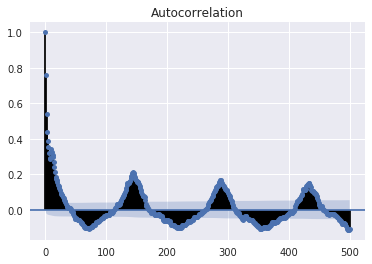

In [23]:
plot_acf(sample.base[series], lags=500)
pyplot.show()

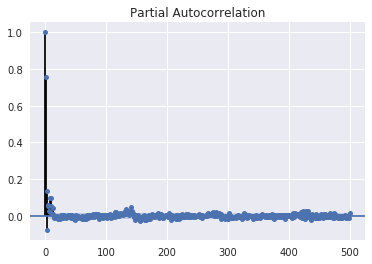

In [24]:
plot_pacf(sample.base[series], lags=500)
pyplot.show()

Looks like some autocorrelation past 1, possibly more. So, probably some pretty intese autocorrelataion. 

Is that oscilation something to look into?

### Seasonal Decompose

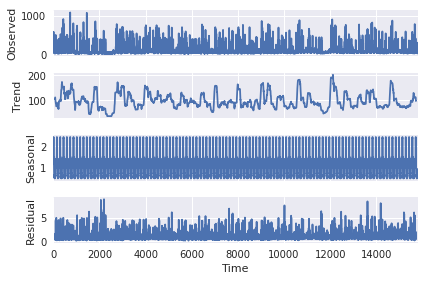

In [26]:
%matplotlib inline

#model = 'additive'
model = 'multiplicitive'

freq = 144
#freq = 1008

#result = seasonal_decompose(sample.base[series_log].values, model=model, freq=freq)
result = seasonal_decompose(sample.base[series].values, model=model, freq=freq)

# Out
result.plot()
pyplot.show()

In [27]:
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

NameError: name 'DataFrame' is not defined

(array([ 214.,  492., 1404., 2965., 3771., 3010., 1695., 1162.,  656.,
         131.]),
 array([-9.17092008, -7.26822517, -5.36553027, -3.46283537, -1.56014046,
         0.34255444,  2.24524934,  4.14794424,  6.05063915,  7.95333405,
         9.85602895]),
 <a list of 10 Patch objects>)

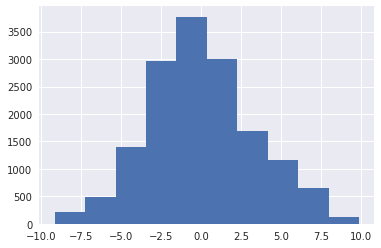

In [72]:
residuals = result.resid[freq:len(result.resid)-freq]
plt.hist(residuals)

### STL Decompose

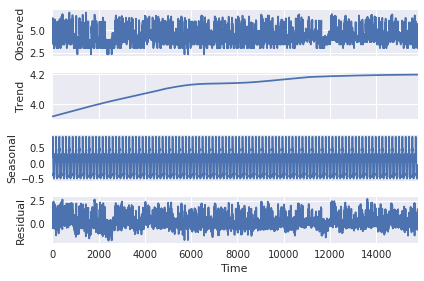

In [29]:
%matplotlib inline

# Decompose
result = decompose(sample.base[series_log].values, period=freq)

# Out
result.plot()
pyplot.show()

In [ ]:
residuals = result.resid[freq:len(result.resid)-freq]
#hist = histogram(residuals)
plt.hist(residuals)

Trend:
    - range of trend scales roughly inverse to freq
    - same for mult v add (because same rolling mean method)
    - even at the day level, range is ~20% of observed. So small scale trend
    - makes a case for stationary as well
Seasonal:
    - looks roughly the same shape on multiplicative 
    - just scaled up
    - hard to check for consistency at day level, but month seems ok
Residual:
    - either a high season, low residual, or low season high residual
    - looks different shape though? Not sure what this is.

In [30]:
# How to calculate R2 w/ moving trend? Or is yhat just the mean, not trend? Should it be of detrend?
# R_SQR should be high or low, based on https://people.maths.bris.ac.uk/~magpn/Research/LSTS/TOS.html?
result = seasonal_decompose(sample.base[series].values, model=model, two_sided=two_side, freq=period)
print(result.resid[period:len(result.resid)-period])

ss_res = [(res*res for res in result.resid[period:])]



NameError: name 'two_side' is not defined

In [31]:
#sample.base['time']
sample.base.index

DatetimeIndex(['2016-01-11 17:00:00', '2016-01-11 17:10:00',
               '2016-01-11 17:20:00', '2016-01-11 17:30:00',
               '2016-01-11 17:40:00', '2016-01-11 17:50:00',
               '2016-01-11 18:00:00', '2016-01-11 18:10:00',
               '2016-01-11 18:20:00', '2016-01-11 18:30:00',
               ...
               '2016-04-30 06:40:00', '2016-04-30 06:50:00',
               '2016-04-30 07:00:00', '2016-04-30 07:10:00',
               '2016-04-30 07:20:00', '2016-04-30 07:30:00',
               '2016-04-30 07:40:00', '2016-04-30 07:50:00',
               '2016-04-30 08:00:00', '2016-04-30 08:10:00'],
              dtype='datetime64[ns]', name='time', length=15788, freq=None)

### AR (I) MA

https://stats.stackexchange.com/questions/251480/statsmodels-says-arima-is-not-appropriate-because-series-is-not-stationary-how

In [70]:
from statsmodels.tsa.arima_model import ARIMA
 
arima_order = (5,1,0)

# fit model
X = sample.base[series]

X = X.astype('float64')

arima = ARIMA(X, order=arima_order)
#arima = ARIMA(sample.base[series], order=arima_order)
arima_fit = arima.fit(isp=0)
print(arima_fit.summary())


/home/nathaniel/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/home/nathaniel/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                             ARIMA Model Results                              
Dep. Variable:          D.tempurature   No. Observations:                15787
Model:                 ARIMA(5, 1, 0)   Log Likelihood               20611.482
Method:                       css-mle   S.D. of innovations              0.066
Date:                Tue, 01 Jan 2019   AIC                         -41208.963
Time:                        16:46:15   BIC                         -41155.295
Sample:                    01-11-2016   HQIC                        -41191.201
                         - 04-30-2016                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -5.869e-05      0.004     -0.015      0.988      -0.008       0.007
ar.L1.D.tempurature     0.9323      0.008    117.411      0.000       0.917       0.948
ar.L2.D.tempurat

/home/nathaniel/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


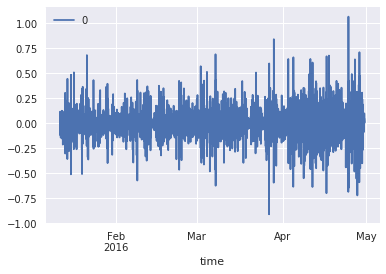

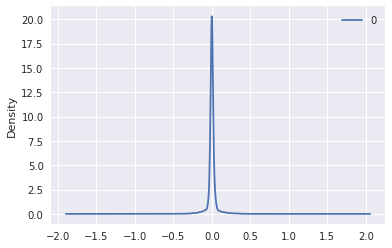

                  0
count  15787.000000
mean       0.000003
std        0.065580
min       -0.909887
25%       -0.011277
50%        0.000004
75%        0.011293
max        1.067886


In [71]:
from pandas import DataFrame

# plot residual errors
residuals = DataFrame(arima_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())







# Tempurature

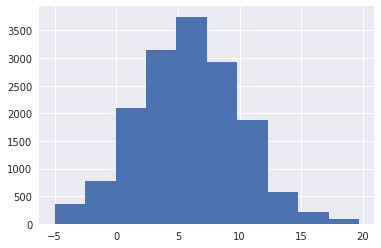

In [50]:
series='tempurature'
sample.base[series].hist()

plt.show()

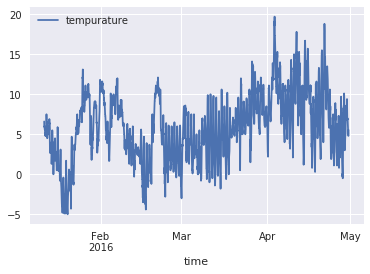

In [51]:
sample.base.plot(kind='line', x=sample.base.index, y=series)

Looks fairly gaussian, just going to go for it.

### Stationality
https://people.maths.bris.ac.uk/~magpn/Research/LSTS/TOS.html

In [37]:
result = sample.stationality(series)

ADF Statistic: -8.118715
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


H(0): Has unit root, is non stationary

H(1): No unit root, is stationary

p = 0 => Reject (p<0.05)

ADF is higher, but still stational. Same critical values though, so maybe I am implimenting this method wrong, or something? Temp does look a little less stationary, but no super distinct trend

In [53]:
result = sample.stationality(series)

ADF Statistic: -8.118715
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Slightly lower ADF on the log, but still tiny p, so maybe it really is stationary.

### Auto Corr/Cov
https://people.maths.bris.ac.uk/~magpn/Research/LSTS/LACF.html

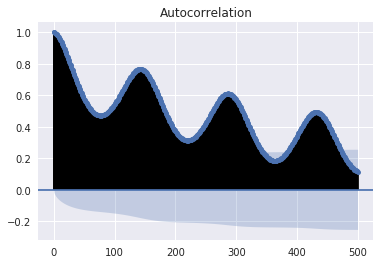

In [54]:
plot_acf(sample.base[series], lags=500)
pyplot.show()

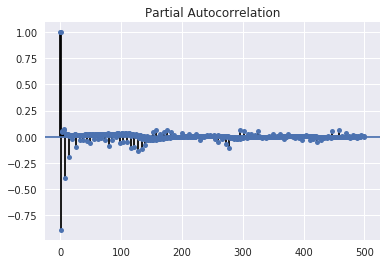

In [55]:
plot_pacf(sample.base[series], lags=500)
pyplot.show()

So HIGH autocorr

### Seasonal Decompose

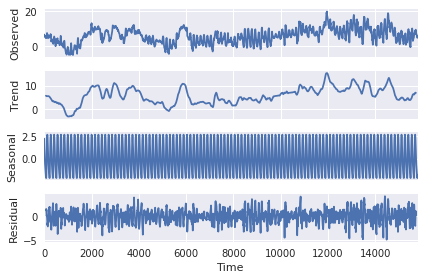

In [59]:
%matplotlib inline

model = 'additive'
#model = 'multiplicitive'

freq = 144
#freq = 1008

#result = seasonal_decompose(sample.base[series_log].values, model=model, freq=freq)
result = seasonal_decompose(sample.base[series].values, model=model, freq=freq)

# Out
result.plot()
pyplot.show()

In [60]:
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

NameError: name 'DataFrame' is not defined

(array([  63.,  166.,  586., 1782., 3280., 4386., 3287., 1335.,  536.,
          79.]),
 array([-4.86069505, -3.95827915, -3.05586325, -2.15344734, -1.25103144,
        -0.34861554,  0.55380036,  1.45621626,  2.35863217,  3.26104807,
         4.16346397]),
 <a list of 10 Patch objects>)

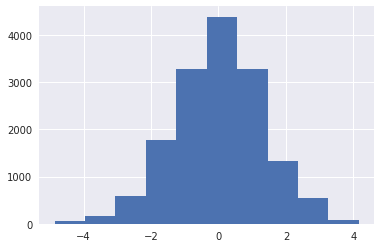

In [61]:
residuals = result.resid[freq:len(result.resid)-freq]
#hist = histogram(residuals)
plt.hist(residuals)

### STL Decompose

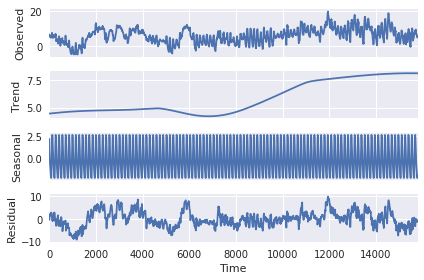

In [63]:
%matplotlib inline

# Decompose
result = decompose(sample.base[series].values, period=freq)

# Out
result.plot()
pyplot.show()

(array([ 214.,  492., 1404., 2965., 3771., 3010., 1695., 1162.,  656.,
         131.]),
 array([-9.17092008, -7.26822517, -5.36553027, -3.46283537, -1.56014046,
         0.34255444,  2.24524934,  4.14794424,  6.05063915,  7.95333405,
         9.85602895]),
 <a list of 10 Patch objects>)

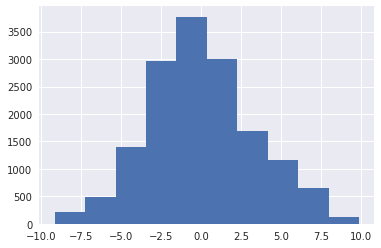

In [64]:
residuals = result.resid[freq:len(result.resid)-freq]
#hist = histogram(residuals)
plt.hist(residuals)

Soooo maybe we need to so some noise reduction or signal identification or something. 

In [65]:
# How to calculate R2 w/ moving trend? Or is yhat just the mean, not trend? Should it be of detrend?
# R_SQR should be high or low, based on https://people.maths.bris.ac.uk/~magpn/Research/LSTS/TOS.html?
result = seasonal_decompose(sample.base[series].values, model=model, two_sided=two_side, freq=period)
print(result.resid[period:len(result.resid)-period])

ss_res = [(res*res for res in result.resid[period:])]



NameError: name 'two_side' is not defined

### AR (I) MA

https://stats.stackexchange.com/questions/251480/statsmodels-says-arima-is-not-appropriate-because-series-is-not-stationary-how

In [70]:
from statsmodels.tsa.arima_model import ARIMA
 
arima_order = (5,1,0)

# fit model
X = sample.base[series]

X = X.astype('float64')

arima = ARIMA(X, order=arima_order)
#arima = ARIMA(sample.base[series], order=arima_order)
arima_fit = arima.fit(isp=0)
print(arima_fit.summary())


/home/nathaniel/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/home/nathaniel/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                             ARIMA Model Results                              
Dep. Variable:          D.tempurature   No. Observations:                15787
Model:                 ARIMA(5, 1, 0)   Log Likelihood               20611.482
Method:                       css-mle   S.D. of innovations              0.066
Date:                Tue, 01 Jan 2019   AIC                         -41208.963
Time:                        16:46:15   BIC                         -41155.295
Sample:                    01-11-2016   HQIC                        -41191.201
                         - 04-30-2016                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -5.869e-05      0.004     -0.015      0.988      -0.008       0.007
ar.L1.D.tempurature     0.9323      0.008    117.411      0.000       0.917       0.948
ar.L2.D.tempurat

/home/nathaniel/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


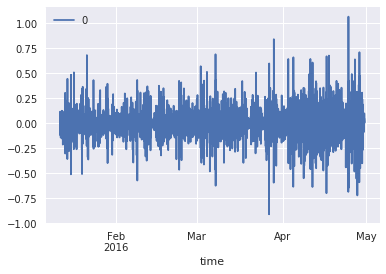

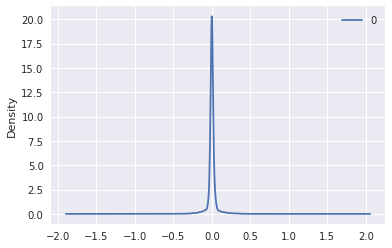

                  0
count  15787.000000
mean       0.000003
std        0.065580
min       -0.909887
25%       -0.011277
50%        0.000004
75%        0.011293
max        1.067886


In [71]:
from pandas import DataFrame

# plot residual errors
residuals = DataFrame(arima_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

# Light Energy

### Seasonal Decompose

In [ ]:
series='light'

In [ ]:
%matplotlib inline

result = seasonal_decompose(sample.base[series].values, model=model, two_sided=two_side, freq=period)

# Out
result.plot()
pyplot.show()

### STL Decompose

In [ ]:
%matplotlib inline

# Decompose
result = decompose(sample.base[series].values, period=period)

# Out
result.plot()
pyplot.show()

# Humidity

### Seasonal Decompose

In [ ]:
%matplotlib inline

# Decompose
result = seasonal_decompose(sample.base['humidity'].values, model=model, two_sided=two_side, freq=period)

# Out
result.plot()
pyplot.show()

In [ ]:
print(result)

### STL Decompose

In [ ]:
%matplotlib inline

# Decompose
result = decompose(sample.base['humidity'].values, period=period)

# Out
result.plot()
pyplot.show()

# Decomp

## Stationality

## DF Test
https://machinelearningmastery.com/time-series-data-stationary-python/

# Decomp

# Seasonal Decompose

# Temp

In [ ]:
%matplotlib inline

# Decompose
result = seasonal_decompose(sample.base['tempurature'].values, model=model, two_sided=two_side, freq=period)

# Out
result.plot()
pyplot.show()

# Dewpoint

In [ ]:
%matplotlib inline

# Decompose
result = seasonal_decompose(sample.base['tdewpoint'].values, model=model, two_sided=two_side, freq=period)

# Out
result.plot()
pyplot.show()

# Pressure

In [ ]:
%matplotlib inline

# Decompose
result = seasonal_decompose(sample.base['pressure'].values, model=model, two_sided=two_side, freq=period)

# Out
result.plot()
pyplot.show()

# Temp

In [ ]:
%matplotlib inline

# Decompose
result = decompose(sample.base['tempurature'].values, period=period)

# Out
result.plot()
pyplot.show()

# Dewpoint

In [ ]:
%matplotlib inline

# Decompose
result = decompose(sample.base['tdewpoint'].values, period=period)

# Out
result.plot()
pyplot.show()

# Pressure

In [ ]:
%matplotlib inline

# Decompose
result = decompose(sample.base['pressure'].values, period=period)

# Out
result.plot()
pyplot.show()

### Observations

I think most of these trend lines would indicate stationality, i.e. small variations relative to the range.

So, it looks like some genral time series approaches may hit some snags. May have to dip into some signal processing to smooth, maybe initially? These "business level" "time series" may be more meaningful over longer periods, or even just after some noise reduction or smoothing techniques are applie. 

# Signal Processing

So, it looks like some genral time series approaches may hit some snags. May have to dip into some signal processing to smooth, maybe initially? These "business level" "time series" may be more meaningful over longer periods, or even just after some noise reduction or smoothing techniques are applie. 